# Spectral Analysis of the Sonic and Ultima temperatures

In [86]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# ------------------------------------------------------------------------------------------
# Directory Lists

# Find host name
import socket
if socket.gethostname().find('.')>=0:
    name=socket.gethostname()
else:
    name=socket.gethostbyaddr(socket.gethostname())[0]

# Determine which machine the script is running on; set up directory names
if 'btgmm8' in name:
    dirPre = '/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/'
elif 'klapos' in name:
    dirPre = '/Users/karllapo/gdrive/DarkMix/proj/VertHarpExp2017Kloendeel/'

dirPrint = dirPre + 'graphics'
dirProcessedEC = dirPre + 'data/land_station_eddycovar_2m_processed/'
dirProcessedUltima = dirPre + 'data/DTS_UltimaVHSRE_processed'

# Load and prepare the data

In [3]:
# ------------------------------------------------------------------------------------------
# Load processed 2m land station eddy covariance data
os.chdir(dirProcessedEC)
ecObs = xr.open_dataset('VHRSE.eddyCovarObs_2m_land.Raw.nc')

# ------------------------------------------------------------------------------------------
# Distributed temperature sensing observations
os.chdir(dirProcessedUltima)
ultima = xr.open_dataset('VHRSE_ultima_calibrated.nc')
ultima.attrs['locations'] = ultima.attrs['locations'].split(';')

## Interpolate the ultima to the sonic time stamps (~1s -> 0.05s)

In [4]:
# ------------------------------------------------------------------------------------------
# Align the datasets

##### WARNING ######
# This is a VERY slow step. Subsampling the data to only examine the near harp.

ultimaHarpNear = None
ultimaHarpFar = None
for l in ultima.locations:
    if 'vertHarpNear' in l:
        if ultimaHarpNear:
            temp = ultima.swap_dims({'LAF': 'location'}).sel(location=l).swap_dims({'location':'LAF'})
            ultimaHarpNear = xr.concat([ultimaHarpNear, temp], dim='LAF')
        else:
            ultimaHarpNear = ultima.swap_dims({'LAF': 'location'}).sel(location=l).swap_dims({'location':'LAF'})

    if 'vertHarpFar' in l:
        if ultimaHarpFar:
            temp = ultima.swap_dims({'LAF': 'location'}).sel(location=l).swap_dims({'location':'LAF'})
            ultimaHarpFar = xr.concat([ultimaHarpFar, temp], dim='LAF')
        else:
            ultimaHarpFar = ultima.swap_dims({'LAF': 'location'}).sel(location=l).swap_dims({'location':'LAF'})
            
# Reindex ultima to the same time stamp as the sonic
ultimaHarpNear_20Hz = ultimaHarpNear.reindex_like(ecObs)
ultimaHarpFar_20Hz = ultimaHarpFar.reindex_like(ecObs)

# Interpolate Ultima to 20Hz
for LAF in ultimaHarpNear.LAF:
    tempDataCoarse = ultimaHarpNear.sel(LAF=LAF)

    # Near harp -- manually calibrated temperature
    tempDataFine = np.interp(ecObs.time, tempDataCoarse.time, tempDataCoarse.manualTemp, left=np.nan, right=np.nan)
    ultimaHarpNear_20Hz.manualTemp.loc[dict(LAF=LAF)] = tempDataFine

    # Near harp -- default temperature
    tempDataFine = np.interp(ecObs.time, tempDataCoarse.time, tempDataCoarse.defaultTemp, left=np.nan, right=np.nan)
    ultimaHarpNear_20Hz.defaultTemp.loc[dict(LAF=LAF)] = tempDataFine

for LAF in ultimaHarpFar.LAF:
    tempDataCoarse = ultimaHarpFar.sel(LAF=LAF)

    # Far harp -- manually calibrated temperature
    tempDataFine = np.interp(ecObs.time, tempDataCoarse.time, tempDataCoarse.manualTemp, left=np.nan, right=np.nan)
    ultimaHarpFar_20Hz.manualTemp.loc[dict(LAF=LAF)] = tempDataFine

    # Far harp -- default temperature
    tempDataFine = np.interp(ecObs.time, tempDataCoarse.time, tempDataCoarse.defaultTemp, left=np.nan, right=np.nan)
    ultimaHarpFar_20Hz.defaultTemp.loc[dict(LAF=LAF)] = tempDataFine
    
print(ultimaHarpNear_20Hz)
print(ultimaHarpFar_20Hz)

<xarray.Dataset>
Dimensions:        (LAF: 46, time: 2745064)
Coordinates:
  * time           (time) datetime64[ns] 2017-09-04T00:00:00.050000 ...
  * LAF            (LAF) float64 47.35 47.48 47.6 47.73 47.86 47.98 48.11 ...
    location       (LAF) object 'vertHarpNear_1' 'vertHarpNear_1' ...
Data variables:
    manualTemp     (time, LAF) float64 nan nan nan nan nan nan nan nan nan ...
    defaultTemp    (time, LAF) float64 nan nan nan nan nan nan nan nan nan ...
    probeWarmBath  (LAF, time) float64 nan nan nan nan nan nan nan nan nan ...
    probeColdBath  (LAF, time) float64 nan nan nan nan nan nan nan nan nan ...
    fiberStatus    (LAF, time) float64 nan nan nan nan nan nan nan nan nan ...
Attributes:
    LAF_beg:    -83.055
    LAF_end:    449.746
    dLAF:       0.127
    locations:  ['vertHarpNear_1', 'vertHarpNear_2', 'vertHarpNear_3', 'vertH...
<xarray.Dataset>
Dimensions:        (LAF: 46, time: 2745064)
Coordinates:
  * time           (time) datetime64[ns] 2017-09-04T00:00:

## Aggregate the sonic and ultima to 1s, 10s, 100s


(736576.5, 736577.5)

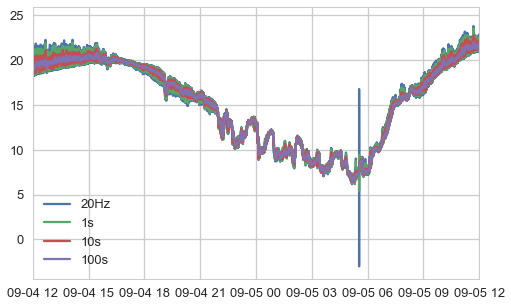

In [75]:
sonicTemp_1s = ecObs.S1_Ts.rolling(time=20).mean() # 20 = 1s running average
sonicTemp_10s = ecObs.S1_Ts.rolling(time=200).mean() # 20 = 10s running average
sonicTemp_100s = ecObs.S1_Ts.rolling(time=2000).mean() # 20 = 100s running average

d1 = datetime(2017, 9, 4, 12, 0, 0)
d2 = datetime(2017, 9, 5, 12, 0, 0)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(ecObs.time, ecObs.S1_Ts, label='20Hz')
ax.plot(sonicTemp_1s.time, sonicTemp_1s, label='1s')
ax.plot(sonicTemp_10s.time, sonicTemp_10s, label='10s')
ax.plot(sonicTemp_100s.time, sonicTemp_100s, label='100s')

ax.legend()
fig.autofmt_xdate
ax.set_xlim(d1, d2)

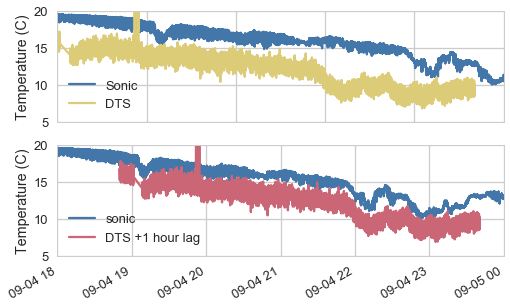

In [5]:
colors = kgraph.SRON(3)
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

# Example of the temperature data -- arbitrary segment.
ax = axes[0]
ax.plot(ecObs.time, ecObs.S1_Ts, color=colors[0], label='Sonic')
ax.plot(ultimaHarpNear_20Hz.time, ultimaHarpNear_20Hz.manualTemp.swap_dims({'LAF': 'location'}).\
         sel(location='vertHarpNear_1').swap_dims({'location': 'LAF'}).isel(LAF=[0]).values,
        label='DTS', color=colors[1])

fig.autofmt_xdate()
ax.legend()
ax.set_xlim(datetime(2017, 9, 4, 18, 0, 0), datetime(2017, 9, 4, 23, 0, 0))
ax.set_ylim(5, 20)
ax.set_ylabel('Temperature (C)');

# Plot the data, but with an hour offset
ax = axes[1]
ax.plot(ecObs.time, ecObs.S1_Ts, color=colors[0], label='sonic')
ax.plot(ultimaHarpNear_20Hz.time
         + pd.Timedelta('1 hours'), ultimaHarpNear_20Hz.manualTemp.swap_dims({'LAF': 'location'}).\
         sel(location='vertHarpNear_1').swap_dims({'location': 'LAF'}).isel(LAF=[0]).values,
        color=colors[2], label='DTS +1 hour lag')
fig.autofmt_xdate()
ax.legend()
ax.set_xlim(datetime(2017, 9, 4, 18, 0, 0), datetime(2017, 9, 5, 0, 0, 0))
ax.set_ylim(5, 20)
ax.set_ylabel('Temperature (C)');


Based on this I am seeing 2 things:  
1) The DTS is lagged by about 1 hour from the sonic  
2) The DTS is biased  

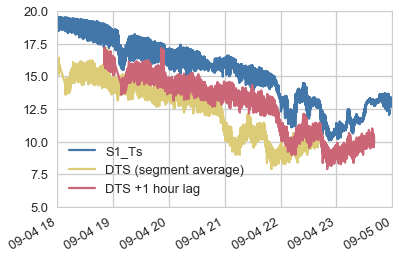

In [6]:
# Same as above, but averaging over an entire segment
colors = kgraph.SRON(3)

plt.plot(ecObs.time, ecObs.S1_Ts, color=colors[0])
plt.plot(ultimaHarpNear_20Hz.time,
         ultimaHarpNear_20Hz.manualTemp.swap_dims({'LAF': 'location'}).
         sel(location='vertHarpNear_1').mean(dim='location').values,
         color=colors[1], label='DTS (segment average)')
plt.gcf().autofmt_xdate()
plt.gca().set_xlim(datetime(2017, 9, 4, 18, 0, 0), datetime(2017, 9, 5, 0, 0, 0))
plt.gca().set_ylim(5, 20)

# Plot the data, but with an hour offset
plt.plot(ultimaHarpNear_20Hz.time
         + pd.Timedelta('1 hours'), ultimaHarpNear_20Hz.manualTemp.swap_dims({'LAF': 'location'}).
         sel(location='vertHarpNear_1').mean(dim='location').values,
         color=colors[2], label='DTS +1 hour lag')
plt.gca().legend()

Using a spatial average reduces the noise (as expected) and I think makes it clear that the data is offset by ~1 hour.

## Remove time lag

In [7]:
# Pull out the two above DTS temperature time series to work on
segmentSignal = ultimaHarpNear_20Hz.manualTemp.swap_dims({'LAF': 'location'}).\
                sel(location='vertHarpNear_1').mean(dim='location').squeeze()
    
binSignal = ultimaHarpNear_20Hz.manualTemp.swap_dims({'LAF': 'location'}).\
                sel(location='vertHarpNear_1').swap_dims({'location': 'LAF'}).isel(LAF=[0]).squeeze()

# Subset the time series for efficiency
d1 = datetime(2017, 9, 4, 17, 0, 0)
d2 = datetime(2017, 9, 5, 2, 0, 0)
dRange = pd.date_range(d1, d2, freq='50ms')
segmentSignal = segmentSignal.sel(time=slice(d1, d2))
binSignal = binSignal.sel(time=slice(d1, d2))

# Sonic data
sonicSignal = ecObs.S1_Ts.sel(time=slice(d1, d2))

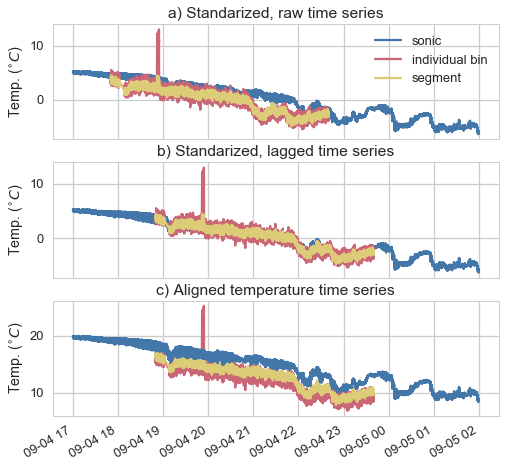

In [8]:
# Lag analysis
from scipy.signal import correlate

# Create time series (standardized)
a_sig = (sonicSignal - np.nanmean(sonicSignal.values)).values
b_sig = (segmentSignal - np.nanmean(segmentSignal.values)).values
c_sig = (binSignal - np.nanmean(binSignal.values)).values

# Find nans
nandex = np.flatnonzero((np.isnan(b_sig)))
# zero them (NOT remove)
b_sig[nandex] = 0
# lag is of length len(a_sig) + len(b_sig) + 1
lag = correlate(a_sig, b_sig)
# Convert to an index in the a/b arrays
maxLag = np.argmax(lag) - len(a_sig) - 1
# Convert to a time (minutes)
maxLag_minutes = maxLag / (20 * 60)
# Re-add the nans for plotting
b_sig[np.flatnonzero(b_sig == 0)] = np.nan
c_sig[np.flatnonzero(c_sig == 0)] = np.nan

fig, axesTs = plt.subplots(3, 1, figsize=(8, 8))
ax = axesTs[0]

# Original time series with mean removed (standardized)
ax.plot(dRange, a_sig, label='sonic', color=colors[0])
ax.plot(dRange, c_sig, label='individual bin', color=colors[2])
ax.plot(dRange, b_sig, label='segment', color=colors[1])

ax.legend()
ax.set_title('a) Standarized, raw time series')
ax.set_ylabel('Temp. ($^{\circ} C$)')
fig.autofmt_xdate()

# Time series at maximum convolution/lag
ax = axesTs[1]

ax.plot(dRange, a_sig, label='sonic', color=colors[0])
ax.plot(dRange + pd.Timedelta(str(maxLag_minutes) + ' minutes'), c_sig, label='individual bin', color=colors[2])
ax.plot(dRange + pd.Timedelta(str(maxLag_minutes) + ' minutes'), b_sig, label='segment', color=colors[1])

ax.set_title('b) Standarized, lagged time series')
ax.set_ylabel('Temp. ($^{\circ} C$)')

# Re-plot lagged timeseries
ax = axesTs[2]
ax.plot(binSignal.time + pd.Timedelta(str(maxLag_minutes) + ' minutes'), binSignal.values, color=colors[2])
ax.plot(segmentSignal.time + pd.Timedelta(str(maxLag_minutes) + ' minutes'), segmentSignal.values, color=colors[1])
ax.plot(sonicSignal.time, sonicSignal.values, color=colors[0])

ax.set_title('c) Aligned temperature time series')
ax.set_ylabel('Temp. ($^{\circ} C$)')
fig.autofmt_xdate()

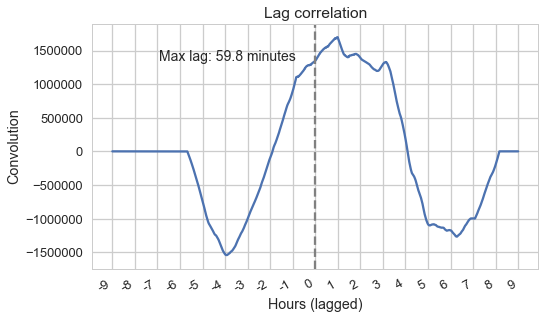

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(lag)
ax.plot([len(lag) / 2, len(lag) / 2], [min(lag) - 200000, max(lag) + 200000], '--', color='0.5')
ax.text( 0.15, 0.85, 'Max lag: ' + '{:04.1f}'.format(maxLag_minutes) + ' minutes',
        transform=ax.transAxes, fontdict={'fontsize': 14})

ax.set_ylim(min(lag) - 200000, max(lag) + 200000)
ax.set_title('Lag correlation')
hours = np.arange(0, len(lag), 20 * 60 * 60);
ax.set_xticks(hours)
ax.set_xticklabels(np.arange(0, len(hours)) - 9);
ax.set_xlabel('Hours (lagged)')
ax.set_ylabel('Convolution')
fig.autofmt_xdate()


Finally got this working. The critical piece is to not _remove_ bad values (e.g., nans) but to zero pad them. Christoph's code was a huge help in figuring this out.

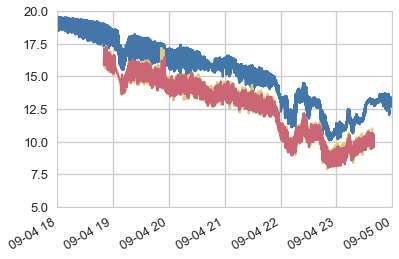

In [10]:
# if statement to prohibit multiple time lag corrections by re-running code block
lagCorrection = True
if lagCorrection:
    # Correct the Ultima data
    
    # Near harp
    ultimaHarpNear_20Hz['time'] = ultimaHarpNear_20Hz.time + pd.Timedelta(str(maxLag_minutes) + ' minutes')
    ultimaHarpNear['time'] = ultimaHarpNear.time + pd.Timedelta(str(maxLag_minutes) + ' minutes')

    # Far harp
    ultimaHarpFar_20Hz['time'] = ultimaHarpFar_20Hz.time + pd.Timedelta(str(maxLag_minutes) + ' minutes')
    ultimaHarpFar['time'] = ultimaHarpFar.time + pd.Timedelta(str(maxLag_minutes) + ' minutes')
        
    # Same as above, but averaging over an entire segment
    colors = kgraph.SRON(3)

    plt.plot(ecObs.time, ecObs.S1_Ts, color=colors[0])
    plt.plot(ultimaHarpNear_20Hz.time,
             ultimaHarpNear_20Hz.manualTemp.swap_dims({'LAF': 'location'}).
             sel(location='vertHarpNear_1').mean(dim='location').values,
             color=colors[1], label='Near Harp (segment average)')
    plt.plot(ultimaHarpFar_20Hz.time,
             ultimaHarpFar_20Hz.manualTemp.swap_dims({'LAF': 'location'}).
             sel(location='vertHarpFar_1').mean(dim='location').values,
             color=colors[2], label='DTS (segment average)')
    plt.gcf().autofmt_xdate()
    plt.gca().set_xlim(datetime(2017, 9, 4, 18, 0, 0), datetime(2017, 9, 5, 0, 0, 0))
    plt.gca().set_ylim(5, 20)
    
    # Save this output for quicker use in the future (may not need?)
    os.chdir(dirPre + 'data')
    ultimaHarpNear_20Hz.to_netcdf('ultimaHarpNear.eddyCovarAligned.nc')
    ultimaHarpFar_20Hz.to_netcdf('ultimaHarpFar.eddyCovarAligned.nc')
    
    lagCorrection = False

Ok, so everything now behaves as I expect. Fantastic! Let's actually do something resembling science now!

# MRD on the eddy-covariance and DTS data

In [141]:
def multires_2var(a, b, M): 
    # Force deep copies of the a and b containers in case we are passing the same variable for both.
    # This should only be necessary when calling the function within a script, rather as a standalone package.
    import copy
    a = copy.copy(a)
    b = copy.copy(b)
    
    # Preallocate matrices
    avg_a = np.ones((M + 1, 2**M)) * np. nan
    avg_b = np.ones((M + 1, 2**M)) * np. nan
    D = np.ones((M)) * -9999

    for inverseModeNum in np.arange(M + 1, dtype='int'):
        modeNum = M - inverseModeNum
        # Length of the decomposition mode window
        windowLength = 2**modeNum
        # Number of the decomposition mode windown
        windowNum = (2**M) / windowLength
        # Sum of the decomposition modes (for power spectrum)
        sumab = 0

        for windex in np.arange(windowNum, dtype='int'):
            # Window indices for summing
            startIndex = (windex * windowLength)
            endIndex = (windex * windowLength) + windowLength

            # Sums over the entire window length
            za = np.mean(a[startIndex:endIndex])
            zb = np.mean(b[startIndex:endIndex])

            # Store avg
            avg_a[inverseModeNum, windex] = za
            avg_b[inverseModeNum, windex] = zb

            # Sums covariance due to window means
            sumab = sumab + za * zb

            # Removes window avg for next modes
            a[startIndex:endIndex] = a[startIndex:endIndex] - za
            b[startIndex:endIndex] = b[startIndex:endIndex] - zb

        if windowNum > 1:
            # Highest mode does not count towards spectral power (single sample)
            D[modeNum] = sumab / windowNum
    return(avg_a, avg_b, D)

## Select a single DTS bin to use for MRD analysis

Find which LAF segment is best correlated with the sonic.

Text(0.5,1,'Vertical Harp Far')

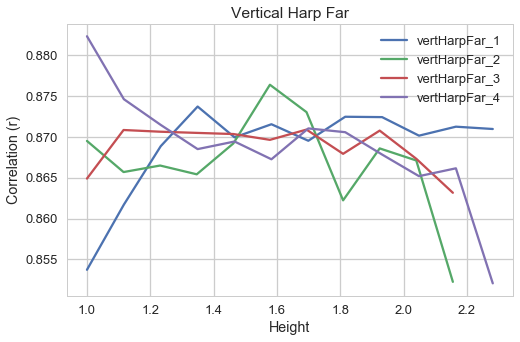

In [12]:
# ------------------------------------------------------------------------------------------
# Correlation between harp and EC
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
maxCorr = 0

for loc in ultima.locations:
    if 'vertHarpFar' in loc:
        segment = ultimaHarpFar_20Hz.swap_dims({'LAF': 'location'}).sel(location=loc).swap_dims({'location': 'LAF'})
        corrFar = []
        for loc_LAF in segment.LAF:
            # Index nans
            nandex = np.flatnonzero(~np.isnan(segment.sel(LAF=loc_LAF).defaultTemp.values))
            r = scipy.stats.pearsonr(segment.sel(LAF=loc_LAF).defaultTemp[nandex], ecObs.S1_Ts[nandex])
            
            # Keep the best correlating segment
            if r[0] > maxCorr:
                maxCorr = r[0]
                segmentFar = segment.sel(LAF=loc_LAF)
            
            # Append to list
            corrFar.append(r[0])
        
        # Height variable to plot against
        vertHeight = np.arange(1, segment.LAF.max() - segment.LAF.min() + 1,
                               (segment.LAF.max() - segment.LAF.min()) / len(segment.LAF))
        ax.plot(vertHeight, corrFar, label=loc)

# Formatting
ax.legend()
ax.set_xlabel('Height')
ax.set_ylabel('Correlation (r)')
ax.set_title('Vertical Harp Far')

Text(0.5,1,'Vertical Harp Near')

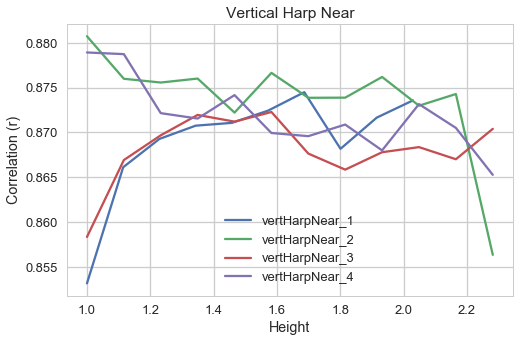

In [13]:
# ------------------------------------------------------------------------------------------
# Correlation between harp and EC
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
maxCorr = 0

for loc in ultimaHarpNear_20Hz.locations:
    if 'vertHarpNear' in loc:
        segment = ultimaHarpNear_20Hz.swap_dims({'LAF': 'location'}).sel(location=loc).swap_dims({'location': 'LAF'})
        corrNear = []
        for loc_LAF in segment.LAF:
            # Index nans
            nandex = np.flatnonzero(~np.isnan(segment.sel(LAF=loc_LAF).defaultTemp.values))
            r = scipy.stats.pearsonr(segment.sel(LAF=loc_LAF).defaultTemp[nandex], ecObs.S1_Ts[nandex])
            
            # Keep the best correlating segment
            if r[0] > maxCorr:
                maxCorr = r[0]
                segmentNear = segment.sel(LAF=loc_LAF)
            
            # Append to list
            corrNear.append(r[0])
        
        # Height variable to plot against
        vertHeight = np.arange(1, segment.LAF.max() - segment.LAF.min() + 1,
                               (segment.LAF.max() - segment.LAF.min()) / len(segment.LAF))
        ax.plot(vertHeight, corrNear, label=loc)

# Formatting
ax.legend()
ax.set_xlabel('Height')
ax.set_ylabel('Correlation (r)')
ax.set_title('Vertical Harp Near')

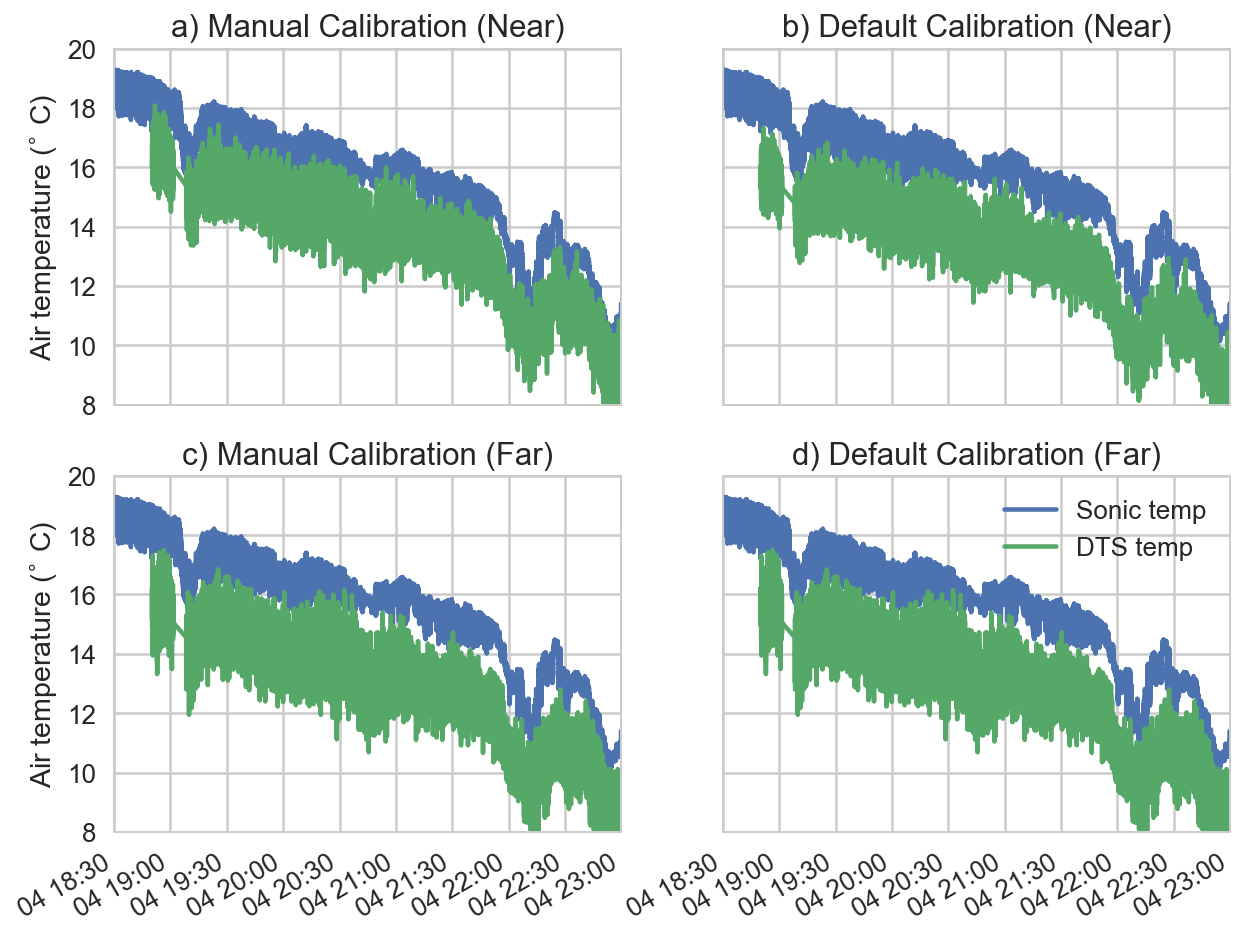

In [88]:
# Compare DTS to EC
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey='row', sharex='col')
axes = axes.flatten()
d1 = datetime(2017, 9, 4, 18, 30, 0)
d2 = datetime(2017, 9, 4, 23, 0, 0)
dRange = pd.date_range(d1, d2, freq='50ms')

# Do a running average

ax = axes[0]
ax.plot(ecObs.time.values, ecObs.S1_Ts)
ax.plot(segmentNear.time.values, segmentNear.manualTemp)
ax.set_ylabel('Air temperature ($^{\circ}$ C)')
ax.set_title('a) Manual Calibration (Near)')
ax.set_xlim(d1, d2)
ax.set_ylim(8, 20)

ax = axes[1]
ax.plot(ecObs.time.values, ecObs.S1_Ts)
ax.plot(segmentNear.time.values, segmentNear.defaultTemp)
ax.set_title('b) Default Calibration (Near)')
ax.set_xlim(d1, d2)
ax.set_ylim(8, 20)

ax = axes[2]
ax.plot(ecObs.time.values, ecObs.S1_Ts)
ax.plot(segmentFar.time.values, segmentFar.defaultTemp)
ax.set_ylabel('Air temperature ($^{\circ}$ C)')
ax.set_title('c) Manual Calibration (Far)')
ax.set_xlim(d1, d2)
ax.set_ylim(8, 20)

ax = axes[3]
ax.plot(ecObs.time.values, ecObs.S1_Ts, label='Sonic temp')
ax.plot(segmentFar.time.values, segmentFar.defaultTemp, label='DTS temp')
ax.legend()
ax.set_title('d) Default Calibration (Far)')
ax.set_xlim(d1, d2)
ax.set_ylim(8, 20)

fig.autofmt_xdate()

Time series of the best correlated DTS section with the sonic temperature for both the far and near harp arrays. Offset is present in both the manual and default temperature calibrations.

In [110]:
# Re-Aalign the sonic and DTS. The time lag includes some fraction of a second which unaligns the datasets
segmentNear = segmentNear.reindex_like(ecObs, method='nearest')
segmentFar = segmentFar.reindex_like(ecObs, method='nearest')

In [142]:
# Run MRD for DTS and sonic
numScales = 16 # 2**16 / (20 * 60) = 54.6 minutes

d1 = datetime(2017, 9, 4, 19, 30, 0)
d2 = datetime(2017, 9, 4, 23, 30, 0)


nearManual = segmentNear.manualTemp.values
nearDefault = segmentNear.defaultTemp.values

farManual = segmentFar.manualTemp.values
farDefault = segmentFar.defaultTemp.values

# Indices of nan values
nandex = np.flatnonzero((~np.isnan(nearManual)) & (~np.isnan(nearDefault))
                        & (~np.isnan(farManual)) & (~np.isnan(farDefault)))

# Remove nans
nearManual = nearManual[nandex]
nearDefault = nearDefault[nandex]
farManual = farManual[nandex]
farDefault = farDefault[nandex]
sonicSignal = ecObs.S1_Ts.values[nandex]

# Time indices
numHours = 4
scales = 2**(np.arange(numScales))
tIndexBeg = np.arange(0, (numHours) * 3600 * 20, 3600 * 20)

# Pre-allocate spectra
spectraSonic = np.zeros((numScales, len(tIndexBeg)))
spectraNearManual = np.zeros((numScales, len(tIndexBeg)))
spectraNearDefault = np.zeros((numScales, len(tIndexBeg)))
spectraFarManual = np.zeros((numScales, len(tIndexBeg)))
spectraFarDefault = np.zeros((numScales, len(tIndexBeg)))

for tNum, beg in enumerate(tIndexBeg):
    print('Working on hour number ' + str(tNum + 1) + ' of 5')
    
    mrd_length = beg + 2 ** numScales
    end = int(beg + mrd_length) + 1
    
    # Make sure there are enough data points to actually perform the analysis
    if (end > len(sonicSignal)) & ( (len(sonicSignal) - beg) / mrd_length > 0.5):
        end = len(sonicSignal)
    
    
    signal = sonicSignal[int(beg): end]
    avg, _, spectraSonic[:, tNum] = multires_2var(signal, signal, numScales)
    
    signal = nearManual[int(beg): end]
    avg, _, spectraNearManual[:, tNum] = multires_2var(signal, signal, numScales)

    signal = nearDefault[int(beg): end]
    avg, _, spectraNearDefault[:, tNum] = multires_2var(signal, signal, numScales)
    
    signal = farManual[int(beg): end]
    avg, _, spectraFarManual[:, tNum] = multires_2var(signal, signal, numScales)
    
    signal = farDefault[int(beg): end]
    avg, _, spectraFarDefault[:, tNum] = multires_2var(signal, signal, numScales)


Working on hour number 1 of 5
Working on hour number 2 of 5
Working on hour number 3 of 5
Working on hour number 4 of 5


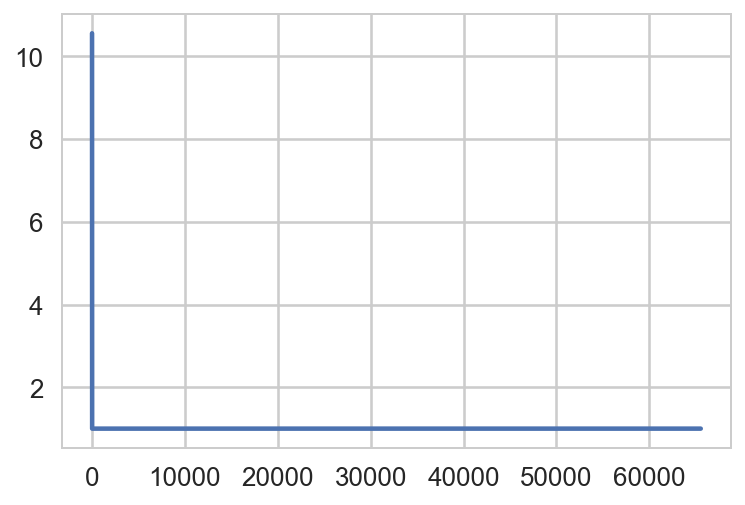

In [125]:
# Normalize the spectra
spectraSonicNormed[:, tNum] = spectraSonic[:, tNum] / scales / 10
spectraNearManualNormed[:, tNum] = spectraNearManual[:, tNum] / scales / 10
spectraNearDefaultNormed[:, tNum] = spectraNearDefault[:, tNum] / scales / 10
spectraFarManualNormed[:, tNum] = spectraFarManual[:, tNum] / scales / 10
spectraFarDefaultNormed[:, tNum] = spectraFarDefault[:, tNum] / scales / 10

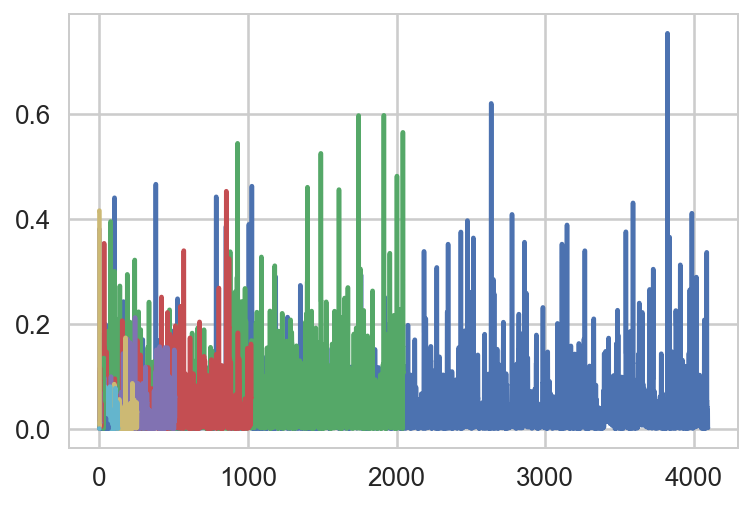

In [148]:
for k in np.arange(0, 12):
    plt.plot(avg[12-k,:]**2,'-')


### To do:
Check normalization implemented in Christoph's code

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


(0.00035432083448465031, 10000)

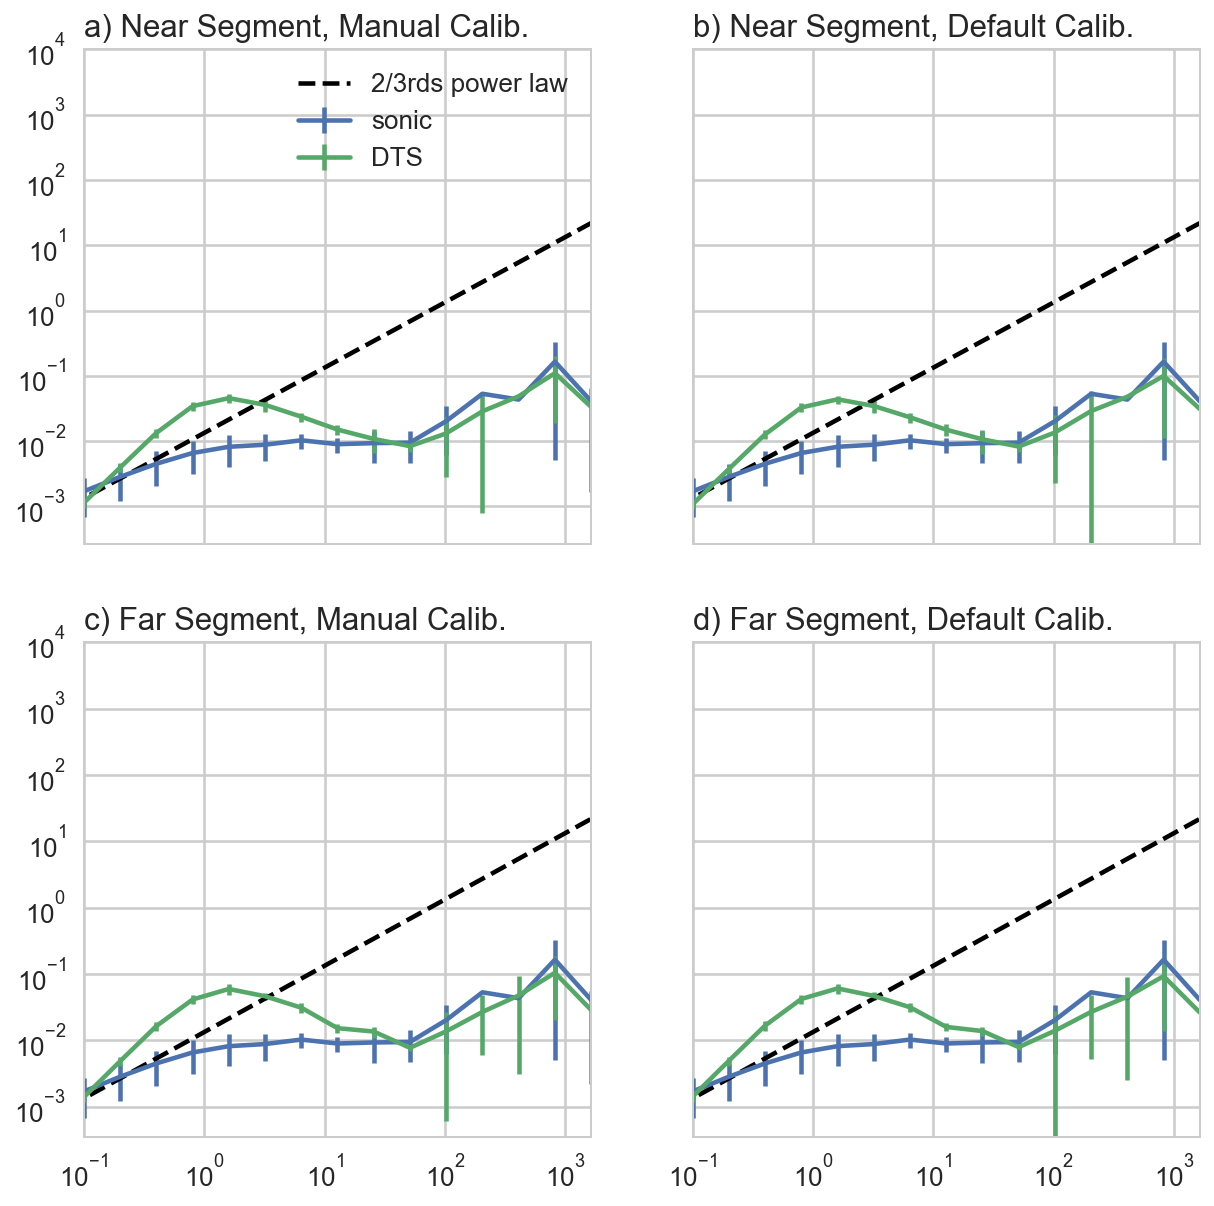

In [149]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex='col', sharey='row')
axes = axes.flatten()

# -------------------------------------------------------------------------
# Near segment manual
ax = axes[0]
ax.errorbar(scales / 20, np.nanmean(spectraSonic, 1), yerr=np.nanstd(spectraSonic, 1), label='sonic')
ax.errorbar(scales / 20, np.nanmean(spectraNearManual, 1), yerr=np.nanstd(spectraNearManual, 1), label='DTS')
ax.plot(scales / 20, 2/3 * scales * 10**(-3), 'k--', label='2/3rds power law')

# Format
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('a) Near Segment, Manual Calib.', loc='left')
ax.legend()
# Remove first mode since it is not meaningful
ax.set_xlim(scales[1] / 20, scales[-1] / 20)
ax.set_ylim(0, 10000)

# -------------------------------------------------------------------------
# Near segment default
ax = axes[1]
ax.errorbar(scales / 20, np.nanmean(spectraSonic, 1), yerr=np.nanstd(spectraSonic, 1), label='sonic')
ax.errorbar(scales / 20, np.nanmean(spectraNearDefault, 1), yerr=np.nanstd(spectraNearDefault, 1), label='DTS')
ax.plot(scales / 20, 2/3 * scales * 10**(-3), 'k--', label='2/3rds power law')

# Format
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('b) Near Segment, Default Calib.', loc='left')
# Remove first mode since it is not meaningful
ax.set_xlim(scales[1] / 20, scales[-1] / 20)
ax.set_ylim(0, 10000)

# -------------------------------------------------------------------------
# Near segment default
ax = axes[2]
ax.errorbar(scales / 20, np.nanmean(spectraSonic, 1), yerr=np.nanstd(spectraSonic, 1), label='sonic')
ax.errorbar(scales / 20, np.nanmean(spectraFarManual, 1), yerr=np.nanstd(spectraFarManual, 1), label='DTS')
ax.plot(scales / 20, 2/3 * scales * 10**(-3), 'k--', label='2/3rds power law')

# Format
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('c) Far Segment, Manual Calib.', loc='left')
# Remove first mode since it is not meaningful
ax.set_xlim(scales[1] / 20, scales[-1] / 20)
ax.set_ylim(0, 10000)

# -------------------------------------------------------------------------
# Near segment default
ax = axes[3]
ax.errorbar(scales / 20, np.nanmean(spectraSonic, 1), yerr=np.nanstd(spectraSonic, 1), label='sonic')
ax.errorbar(scales / 20, np.nanmean(spectraFarDefault, 1), yerr=np.nanstd(spectraFarDefault, 1), label='DTS')
ax.plot(scales / 20, 2/3 * scales * 10**(-3), 'k--', label='2/3rds power law')

# Format
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('d) Far Segment, Default Calib.', loc='left')
# Remove first mode since it is not meaningful
ax.set_xlim(scales[1] / 20, scales[-1] / 20)
ax.set_ylim(0, 10000)

In [113]:
# Moving averages of the best correlated near segment
segmentNear_1s = segmentNear.manualTemp.rolling(time=20).mean() # 20 = 1s running average
segmentNear_10s = segmentNear.manualTemp.rolling(time=200).mean() # 20 = 10s running average
segmentNear_100s = segmentNear.manualTemp.rolling(time=2000).mean() # 20 = 100s running average

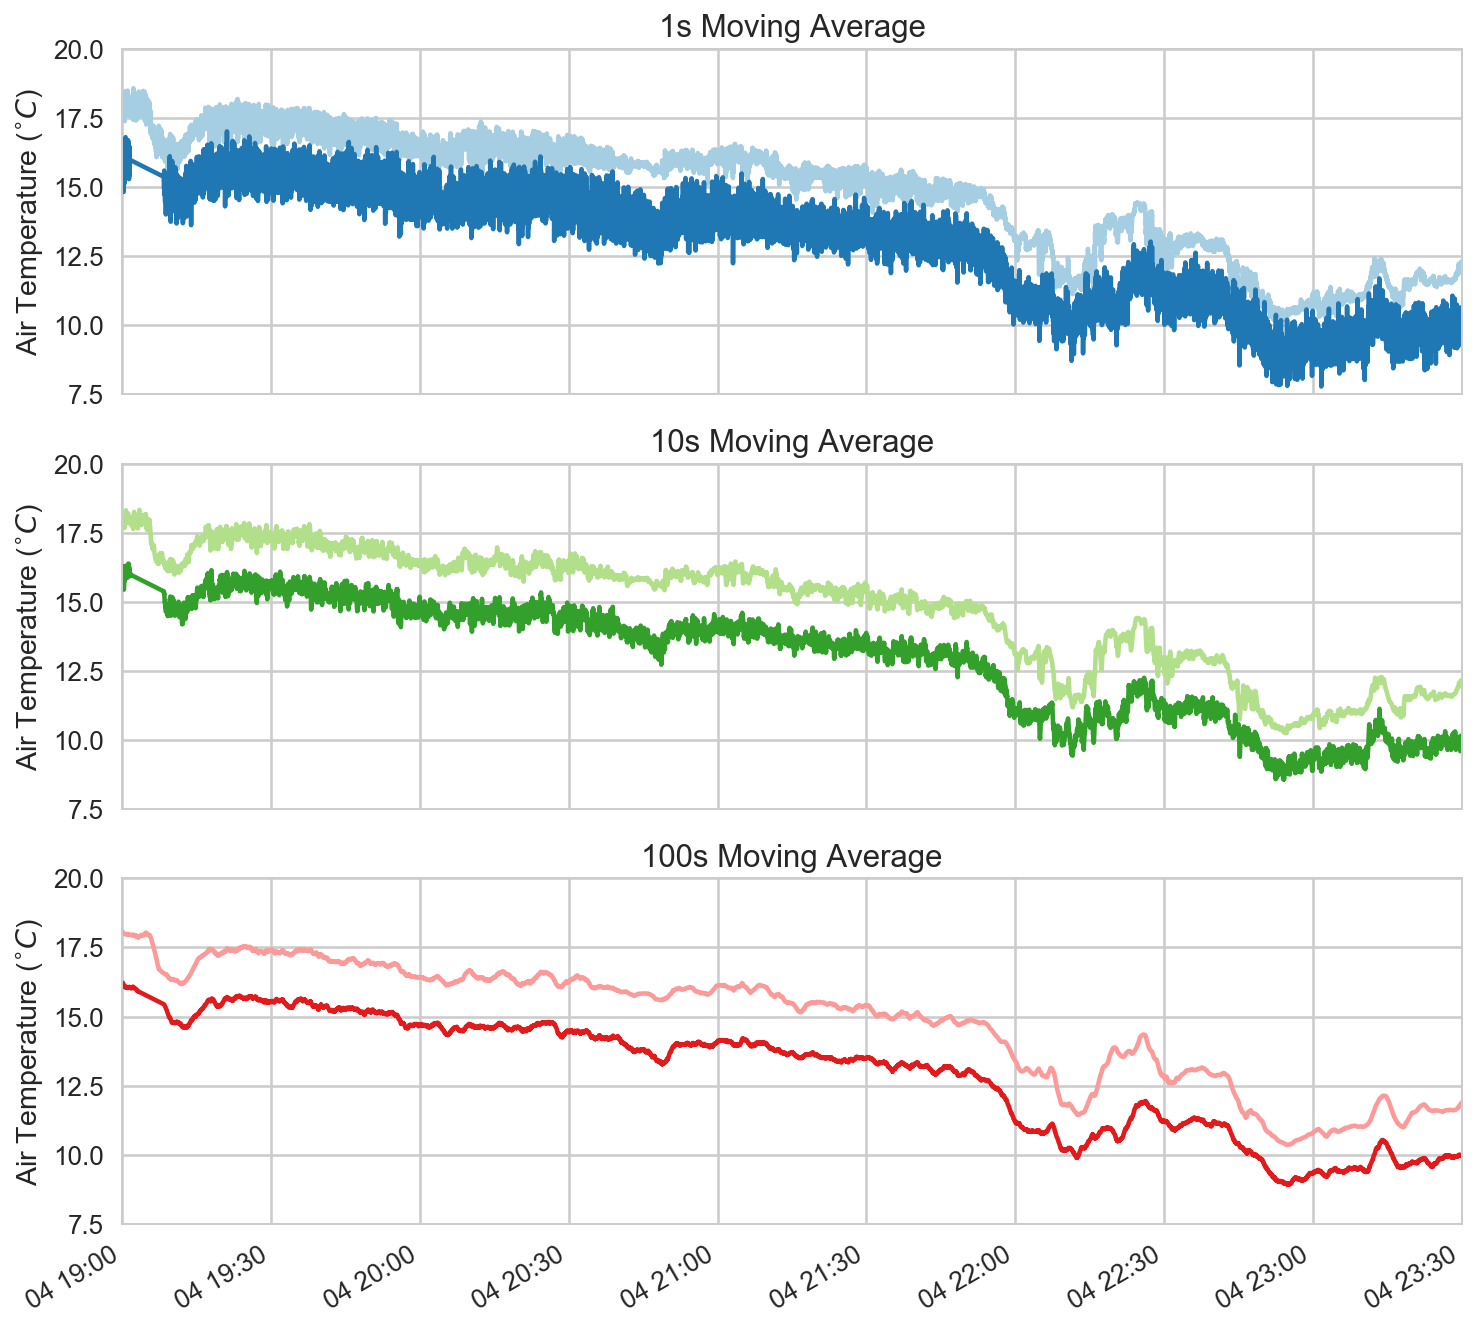

In [114]:
colors = sns.color_palette("Paired")

d1 = datetime(2017, 9, 4, 19, 0, 0)
d2 = datetime(2017, 9, 4, 23, 30, 0)
T1 = 7.5
T2 = 20

fig, axes = plt.subplots(3, 1, figsize=(12, 12))
ax = axes[0]
ax.plot(sonicTemp_1s.time, sonicTemp_1s, label='1s', color=colors[0])
ax.plot(segmentNear_1s.time, segmentNear_1s, color=colors[1])
ax.set_xlim(d1, d2)
ax.set_ylim(T1, T2)
ax.set_ylabel('Air Temperature ($^{\circ} C$)')
ax.set_title('1s Moving Average')

ax = axes[1]
ax.plot(sonicTemp_10s.time, sonicTemp_10s, label='10s', color=colors[2])
ax.plot(segmentNear_10s.time, segmentNear_10s, color=colors[3])
ax.set_xlim(d1, d2)
ax.set_ylim(T1, T2)
ax.set_ylabel('Air Temperature ($^{\circ} C$)')
ax.set_title('10s Moving Average')

ax = axes[2]
ax.plot(sonicTemp_100s.time, sonicTemp_100s, label='100s', color=colors[4])
ax.plot(segmentNear_100s.time, segmentNear_100s, color=colors[5])
ax.set_xlim(d1, d2)
ax.set_ylim(T1, T2)
ax.set_ylabel('Air Temperature ($^{\circ} C$)')
ax.set_title('100s Moving Average')

fig.autofmt_xdate()

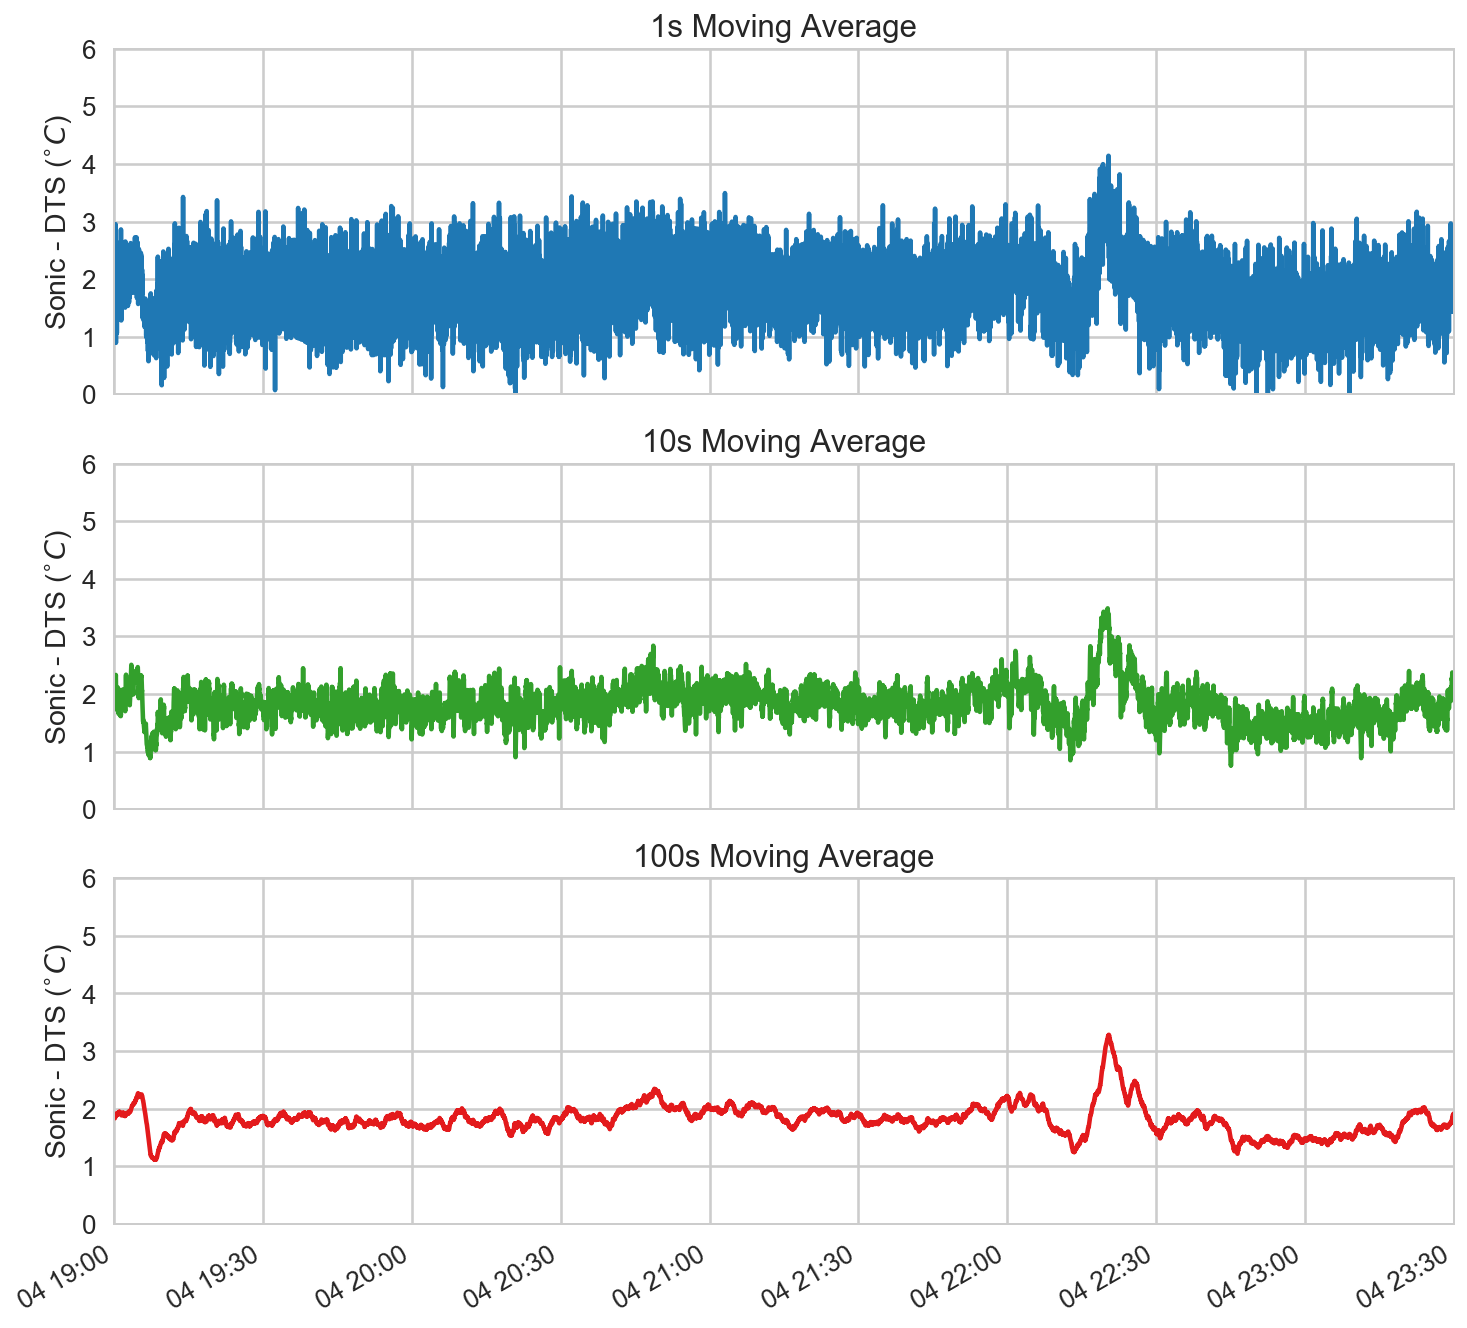

In [117]:

colors = sns.color_palette("Paired")

d1 = datetime(2017, 9, 4, 19, 0, 0)
d2 = datetime(2017, 9, 4, 23, 30, 0)
T1 = 0
T2 = 6

fig, axes = plt.subplots(3, 1, figsize=(12, 12))
ax = axes[0]
ax.plot(sonicTemp_1s.time, sonicTemp_1s.values - segmentNear_1s.values, label='1s', color=colors[1])
ax.set_xlim(d1, d2)
ax.set_ylim(T1, T2)
ax.set_ylabel('Sonic - DTS ($^{\circ} C$)')
ax.set_title('1s Moving Average')

ax = axes[1]
ax.plot(sonicTemp_10s.time, sonicTemp_10s - segmentNear_10s, label='10s', color=colors[3])
ax.set_xlim(d1, d2)
ax.set_ylim(T1, T2)
ax.set_ylabel('Sonic - DTS ($^{\circ} C$)')
ax.set_title('10s Moving Average')

ax = axes[2]
ax.plot(sonicTemp_100s.time, sonicTemp_100s - segmentNear_100s, label='100s', color=colors[5])
ax.set_xlim(d1, d2)
ax.set_ylim(T1, T2)
ax.set_ylabel('Sonic - DTS ($^{\circ} C$)')
ax.set_title('100s Moving Average')

fig.autofmt_xdate()

(8, 20)

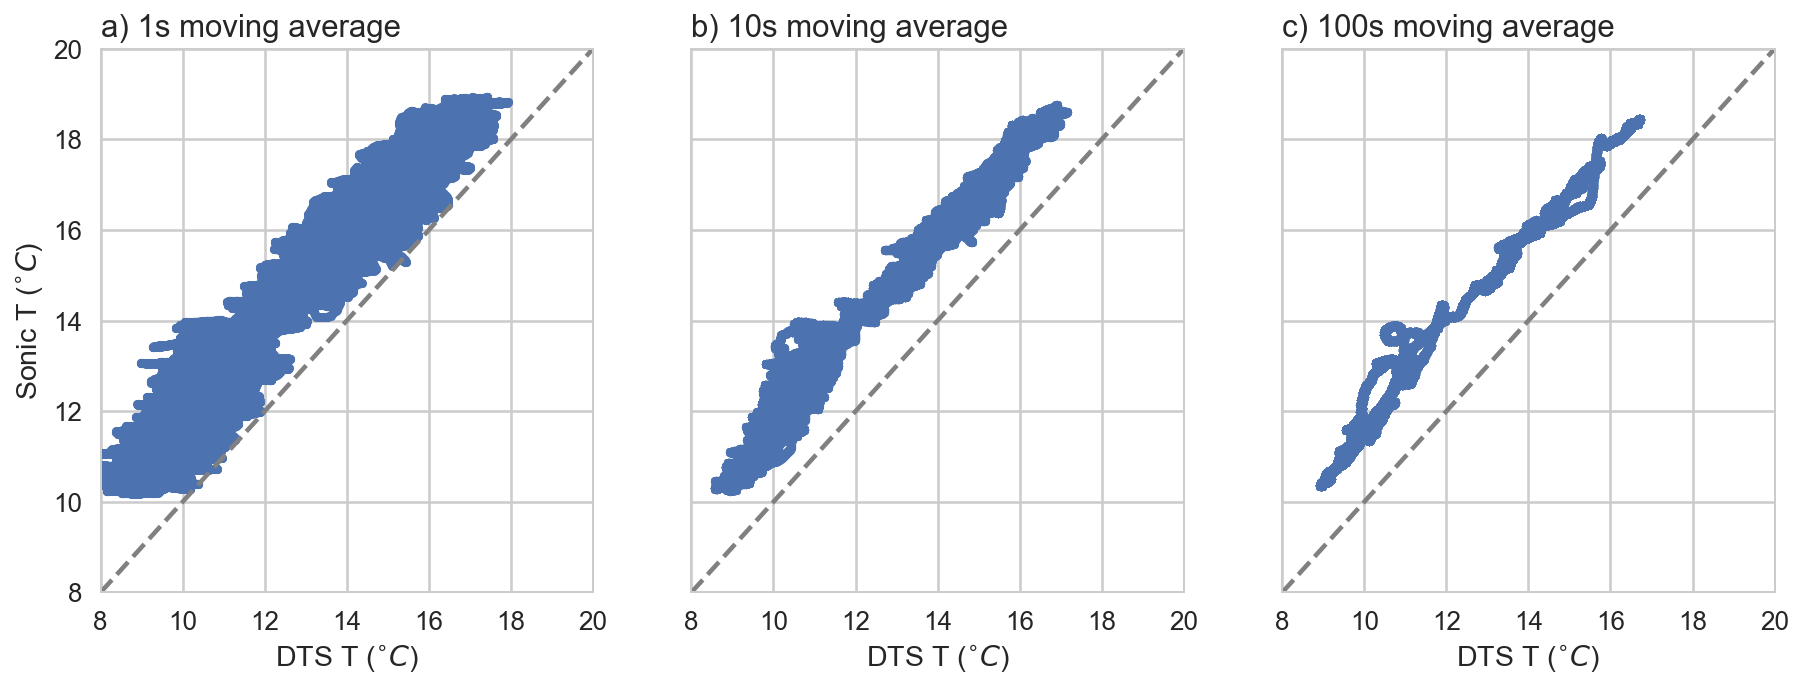

In [120]:
# Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

ax = axes[0]
ax.set_title('a) 1s moving average', loc='left')
ax.plot(segmentNear_1s, sonicTemp_1s, '.')
ax.plot([8, 20], [8, 20], '--', color='0.5')
ax.set_ylabel('Sonic T ($^{\circ} C$)')
ax.set_xlabel('DTS T ($^{\circ} C$)')
ax.set_xlim(8, 20)
ax.set_ylim(8, 20)

ax = axes[1]
ax.set_title('b) 10s moving average', loc='left')
ax.plot(segmentNear_10s, sonicTemp_10s, '.')
ax.plot([8, 20], [8, 20], '--', color='0.5')
ax.set_xlabel('DTS T ($^{\circ} C$)')
ax.set_xlim(8, 20)
ax.set_ylim(8, 20)

ax = axes[2]
ax.set_title('c) 100s moving average', loc='left')
ax.plot(segmentNear_100s, sonicTemp_100s, '.')
ax.plot([8, 20], [8, 20], '--', color='0.5')
ax.set_xlabel('DTS T ($^{\circ} C$)')
ax.set_xlim(8, 20)
ax.set_ylim(8, 20)